In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import os

%load_ext autoreload
%autoreload 2

# Cross testing of methods

In [2]:
data_set = "breast_cancer"

match data_set:
    case "breast_cancer":
        X, true_y = load_breast_cancer(return_X_y=True)

#X, true_y = load_wine(return_X_y=True)
# X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)

cf_amount = 25
random_state = 42
random.seed(random_state)

nc = 2
km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

for cf in cfs:
    print(cf.instance, cf.instance_label)

114 1
281 1
228 1
104 1
432 0
30 0
223 0
517 0
203 0
225 1
284 1
163 1
348 1
159 1
344 1
94 0
99 1
352 0
44 1
549 1
387 1
565 0
370 0
71 1
233 0


In [3]:
def pickle_cfs(cf_obj):
    name = cf_obj['name']
    with open(f'./testdata/cfs/{data_set}/{name}.pkl', 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    with open(f'./testdata/eval/{data_set}/{method_name}.pkl', 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

## Baseline

In [4]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (781) CFs (0)
Re-training surrogate model with data size: 781
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (10) Unique overall (10)
Generated random instances: (3734)
Predicted top: 20 Counterfactuals: 3
Found new best [ 1.78834537 -0.80508343 -0.03102611 -1.20586852  1.32650383 -0.42320519
 -0.29885527  1.14639043 -0.59371141  1.75950747  1.99083953  0.33366619
 -0.14625184  0.29872161  0.40669019 -0.18712594  1.20452939 -0.22646693
  1.06880838  0.38964125 -1.37527439 -0.98638119 -1.27427429  1.35733433
 -0.80068184  0.62713707 -0.12755887  1.52171538  1.7213671   0.98386255], with fitness score 0.3422 (X 0.78972 Y 1.0 F 0.43333), oversampling
Known alternatives: 801
Best instance score 0.3422 (X 0.78

100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


## Baycon

In [5]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (774) CFs (687)
Re-training surrogate model with data size: 774
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (119) Unique overall (119)
Generated random instances: (3714)
Predicted top: 20 Counterfactuals: 20
Found new best [-1.53404353 -0.80508343  1.08591372 -1.20586852  1.32650383 -0.42320519
  0.50805396  0.30983525  0.55375319  1.91835712 -0.23082197 -1.14385933
 -0.7485156  -0.69021737  0.40669019  1.79619691  0.02308669 -0.22646693
 -0.41920995  0.00419713  1.62665812 -0.98638119 -1.27427429 -1.0480379
  1.75481236  0.37628224  1.36983018 -0.14627009  0.04083972  0.98386255], with fitness score 0.3426 (X 0.88984 Y 0.55 F 0.7), oversampling
Known alternatives: 794
Best instance score 0.3426 (X 0.88984 Y 0.55 F 0.7), found on epoch: 1

100%|██████████| 25/25 [17:57<00:00, 43.10s/it] 


## CFDE

In [6]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y)
pickle_res(res, cfde['name'])

Starting on: CF-DE


100%|██████████| 25/25 [00:00<00:00, 48.29it/s]


## CFAE

In [7]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y)
pickle_res(res, cfae['name'])

Starting on: CF-AE


100%|██████████| 25/25 [00:00<00:00, 47.49it/s]


## NeighborSearch

In [8]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch


100%|██████████| 25/25 [00:00<00:00, 43.05it/s]


## Dice Mod

In [9]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([
        # random_opt(instance, gainer.gain)[0][0] 
        adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
    for _ in range(1)])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y)
pickle_res(res, dice_mod['name'])

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 110, score: 0.8499335234278281
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.861102589318129
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 108, score: 0.8905798449976869
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8737501547169958
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.8945683467406988
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 126, score: 0.8606015712462629
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 133, score: 0.9402864917056933
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8942000823153132
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 104, score: 0.8185183627280299
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 109, s

100%|██████████| 25/25 [00:00<00:00, 58.49it/s]


## threshold tree / imm

In [10]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_dtc_prime_cfs = []
tt_imm_cfs = []
tt_imm_prime_cfs = []
for cf in cfs:
    tt_cf, tt_cf_prime = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

    tt_imm_cf, tt_imm_cf_prime = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_imm_prime_cfs.append(cf_data)



tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y)
pickle_res(res, tt_dtc_prime['name'])


tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y)
pickle_res(res, tt_imm_prime['name'])

DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
DTC accuracy: 0.9982425307557118
Starting on: ThresholdTree_DTC


100%|██████████| 25/25 [00:00<00:00, 84.18it/s]


Starting on: ThresholdTree_DTC_Post_Proccesing


100%|██████████| 25/25 [00:00<00:00, 84.21it/s]


Starting on: ThresholdTree_IMM


100%|██████████| 25/25 [00:00<00:00, 102.37it/s]


Starting on: ThresholdTree_IMM_Post_Proccesing


100%|██████████| 25/25 [00:00<00:00, 100.02it/s]


# Loading method counterfactuals

In [11]:
methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print(methodNames)

['Baycon', 'CF-DE', 'dice_mod', 'CF-AE', 'ThresholdTree_IMM_Post_Proccesing', 'Baseline', 'ThresholdTree_IMM', 'ThresholdTree_DTC_Post_Proccesing', 'NeighborSearch', 'ThresholdTree_DTC']


# Loading evaluation results

In [25]:
results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

# Print & plot evaluation results

In [ ]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

for i, n in enumerate(returnNames()):
    row = {}
    for m in methodNames:
        res = results[m]
        print(res)
        res = [row[i] for row in res]
        r = []
        for current in range(cf_amount):
            r.extend([res[current]])
        try:
            r = np.mean(r[0])
        except:
            pass
        row[m] = r
    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=returnNames())
mean_results_df


[[array([0.45077672, 0.2626356 , 0.02854971, ..., 3.04594053, 3.1664143 ,
       3.15514291], shape=(2174,)), array([0.96666667, 0.96666667, 0.96666667, ..., 0.86666667, 0.86666667,
       0.86666667], shape=(2174,)), array([-1.5619055 , -1.549958  , -1.55506648, ..., -1.51209107,
       -1.49279098, -1.49407651], shape=(2174,)), array([False, False, False, ..., False, False, False], shape=(2174,)), np.float64(0.0)], [array([0.7407737 , 0.13771174, 0.16015943, ..., 1.85874485, 3.96570353,
       2.09574986], shape=(2431,)), array([0.96666667, 0.96666667, 0.96666667, ..., 0.83333333, 0.73333333,
       0.83333333], shape=(2431,)), array([-1.64148706, -1.67550029, -1.65869504, ..., -1.5827541 ,
       -1.47413479, -1.57938396], shape=(2431,)), array([False, False, False, ..., False, False, False], shape=(2431,)), np.float64(0.0)], [array([1.86739961, 2.02109285, 1.39528332, ..., 2.60319576, 2.99164372,
       2.72919957], shape=(1532,)), array([0.96666667, 0.96666667, 0.96666667, ..., 0.

Baycon         CF-DE  dice_mod     CF-AE  \
Similarity    1.496414  5.137265e+00  6.490924  6.126594   
Minimality    0.870837  3.333333e-01  0.000000  0.550000   
Plausibility -1.516957 -1.226067e+00 -0.991840 -1.289999   
Validity      0.000460  1.000000e+00  1.000000  0.950000   
Diversity     0.000000  1.370708e-09  1.050595  0.565369   

              ThresholdTree_IMM_Post_Proccesing  Baseline  ThresholdTree_IMM  \
Similarity                             1.673694  7.007601           1.062054   
Minimality                             0.966667  0.397222           0.966667   
Plausibility                          -1.525730 -1.357414          -1.528077   
Validity                               0.000000  0.750000           0.000000   
Diversity                              1.080884  1.372477           1.064040   

              ThresholdTree_DTC_Post_Proccesing  NeighborSearch  \
Similarity                             2.185190        5.513618   
Minimality                             0.000000        0.197778   
Plausibility                          -1.519726       -1.074121   
Validity                               0.000000        1.000000   
Diversity                              0.752900        0.484651   

              ThresholdTree_DTC  
Similarity             1.609514  
Minimality             0.000000  
Plausibility          -1.515991  
Validity               0.000000  
Diversity              0.510214

In [ ]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

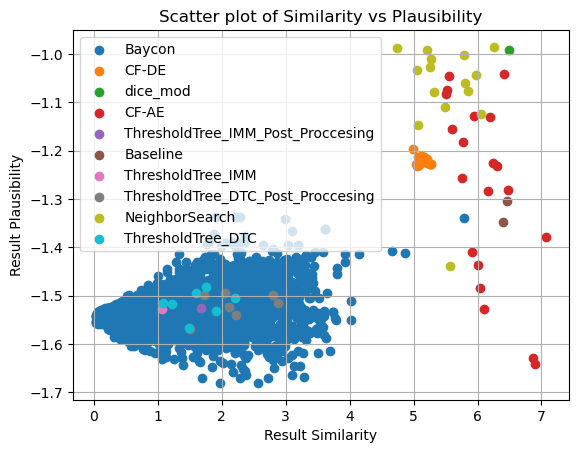

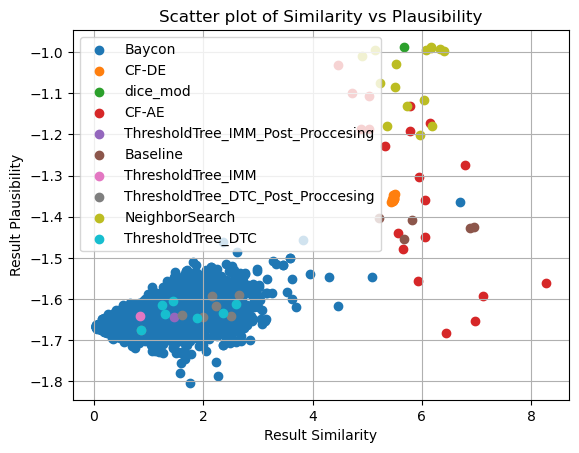

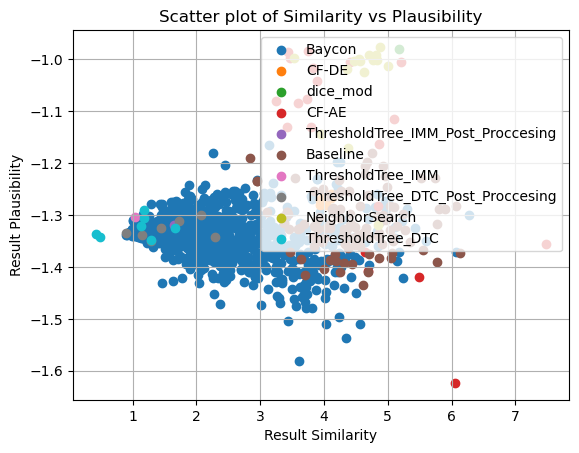

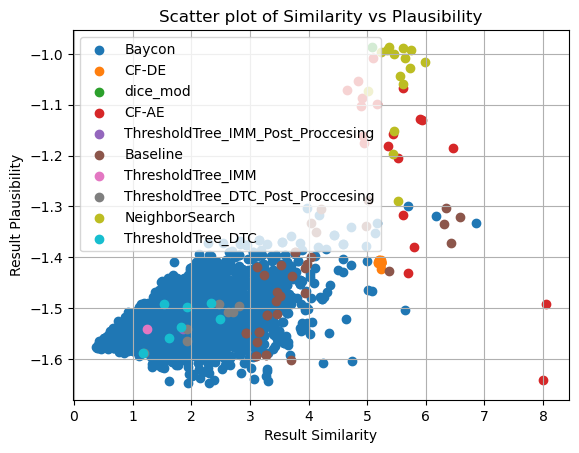

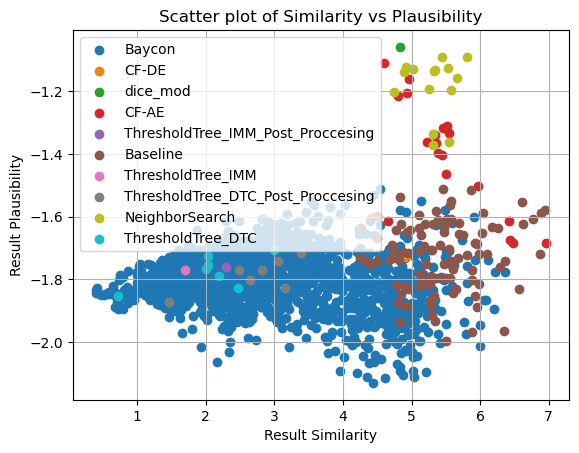

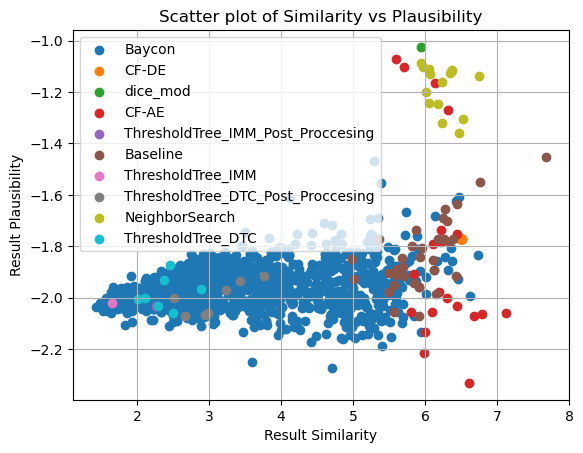

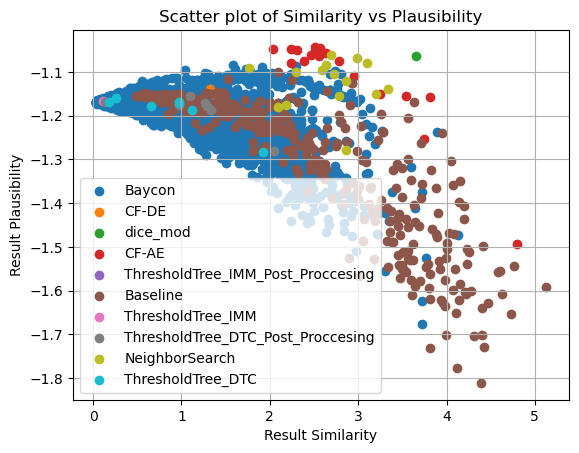

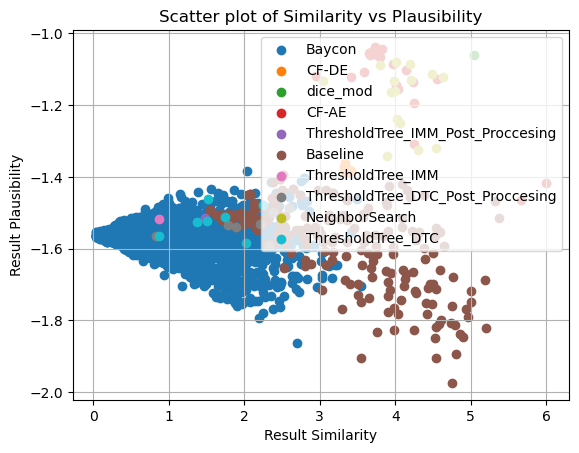

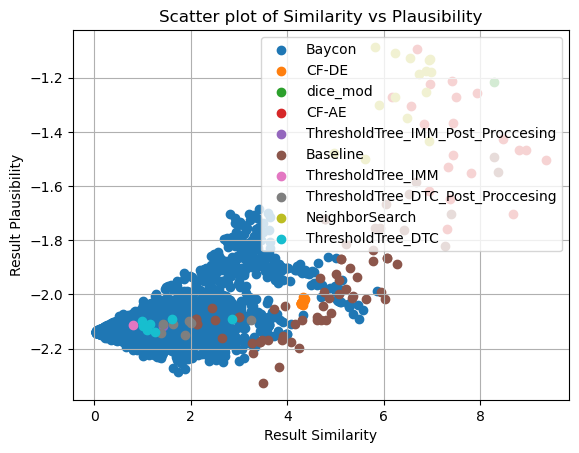

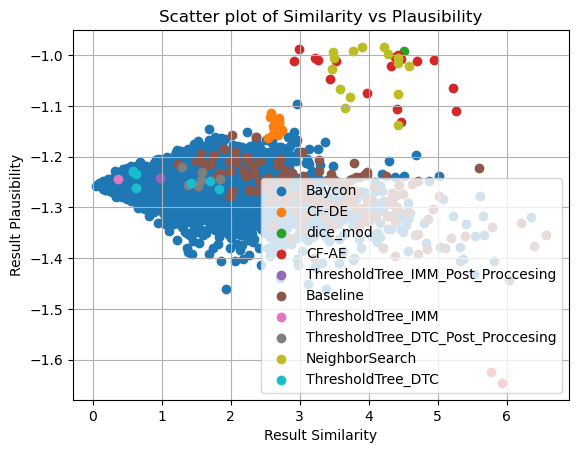

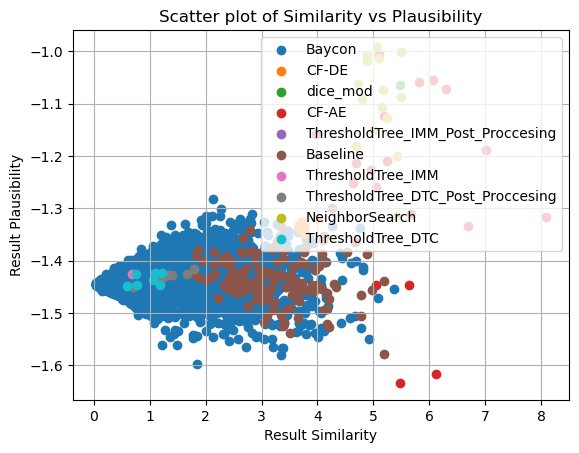

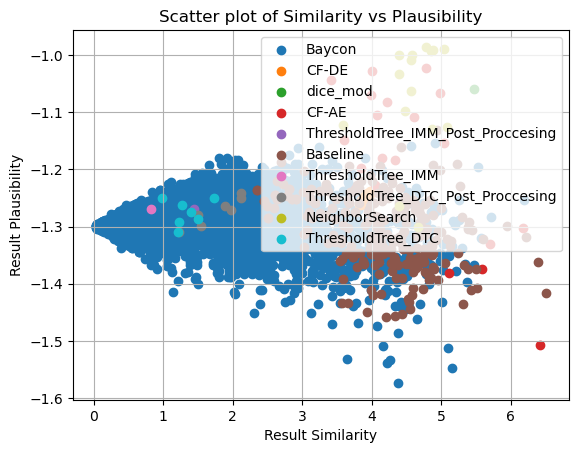

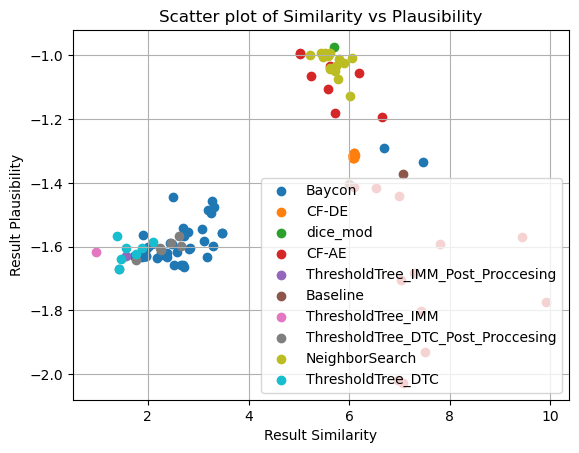

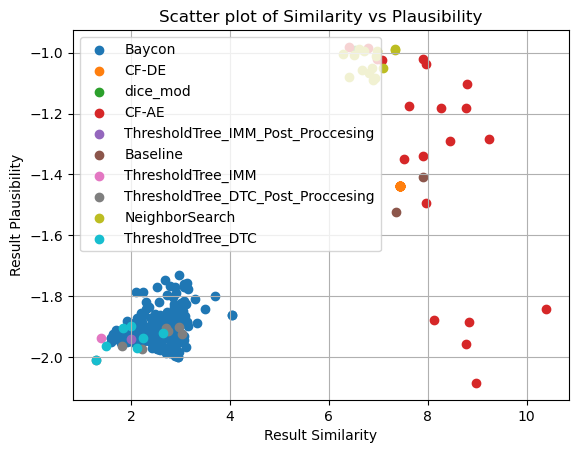

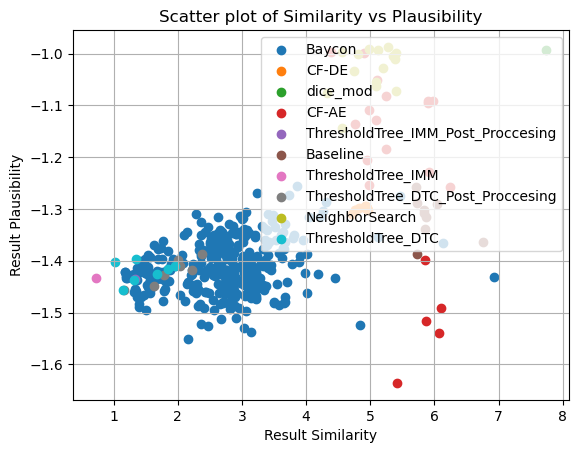

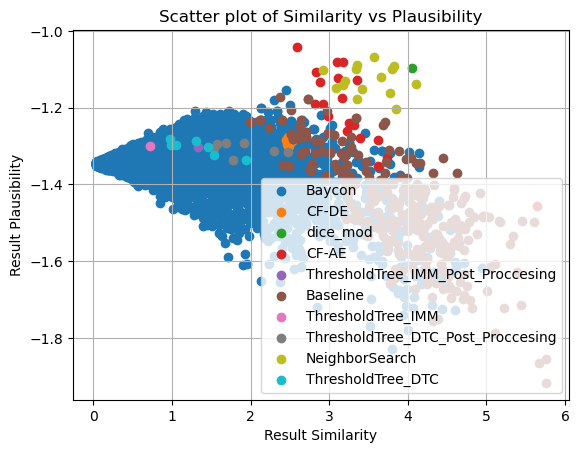

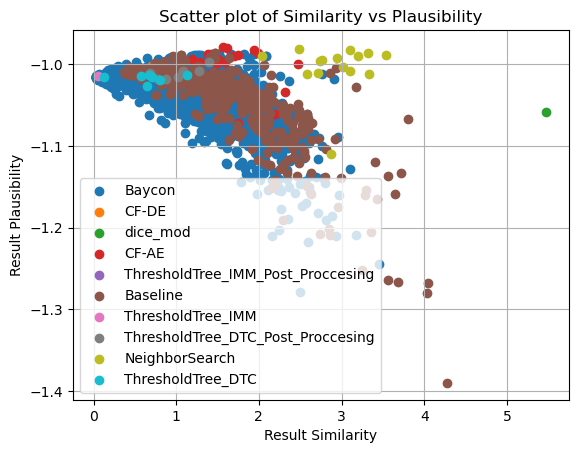

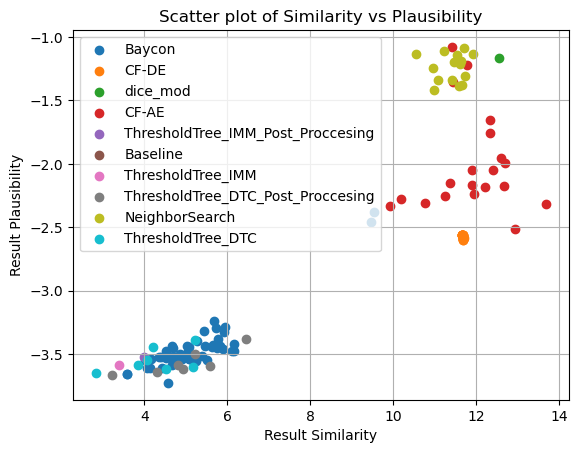

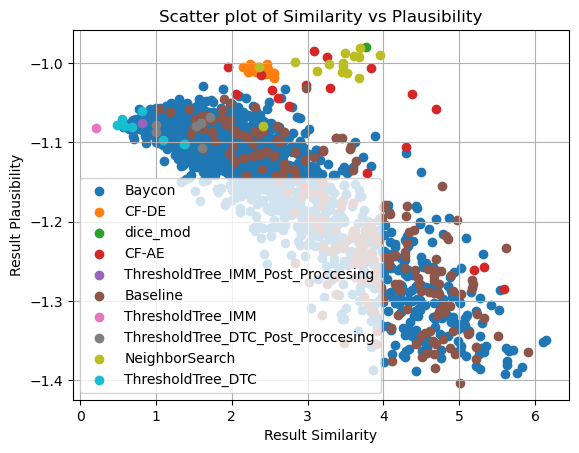

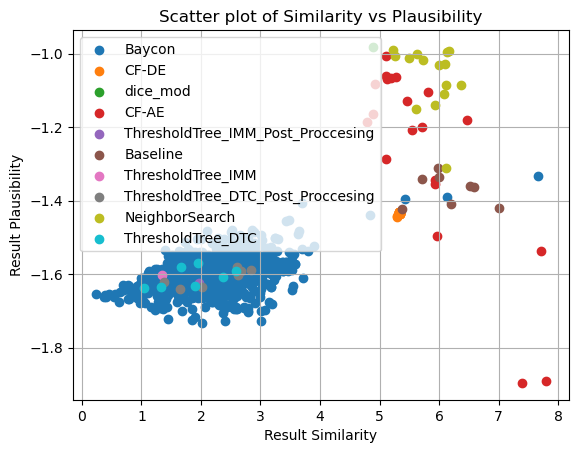

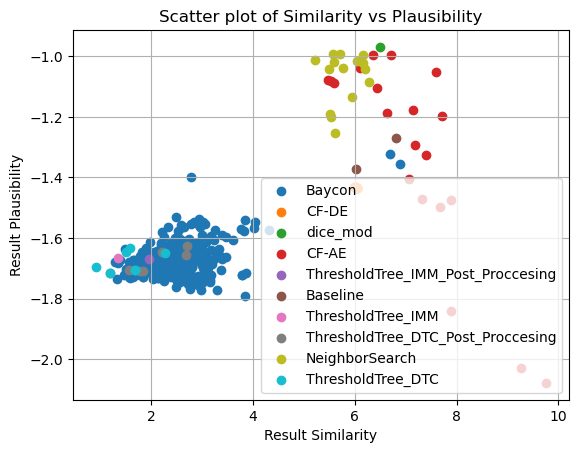

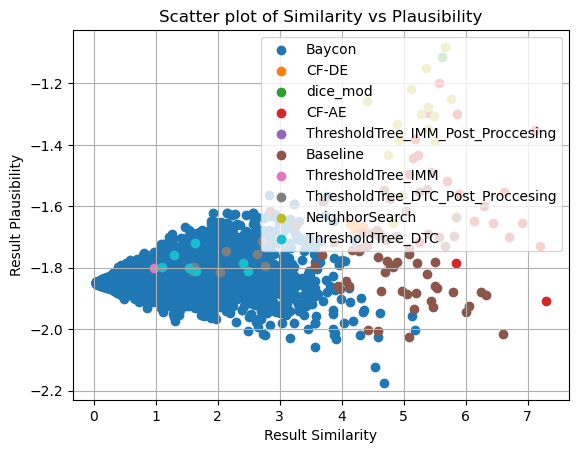

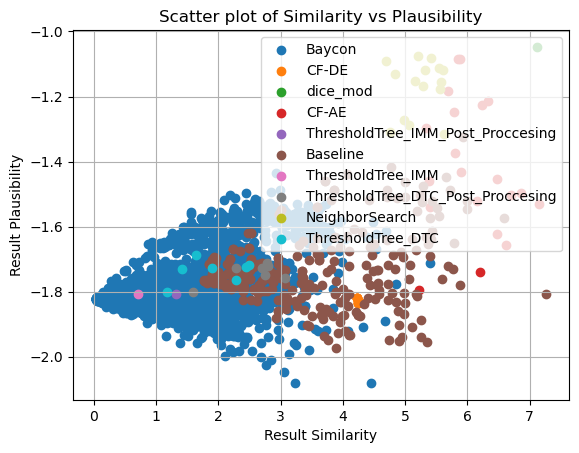

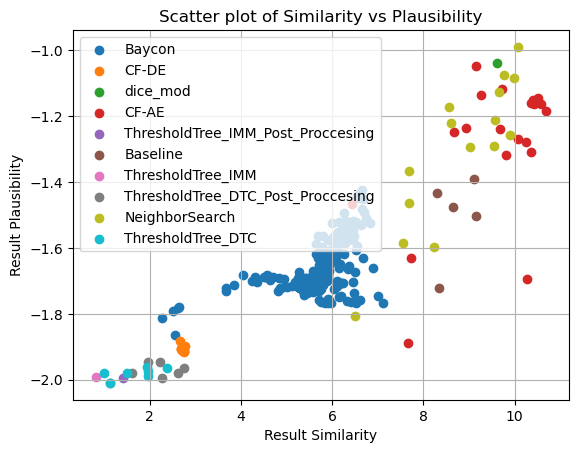

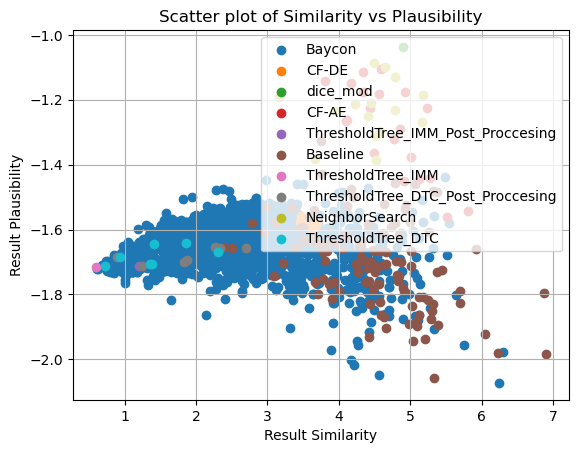

In [ ]:
for i in range(cf_amount):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

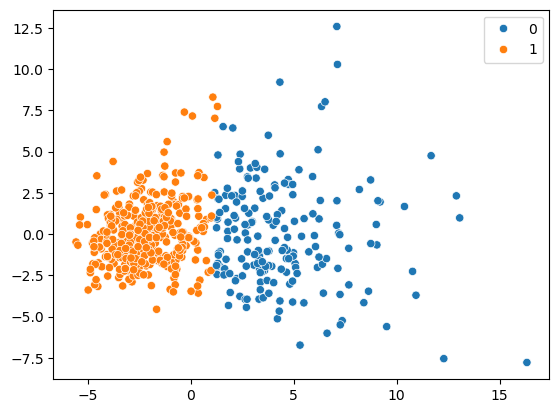

In [ ]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

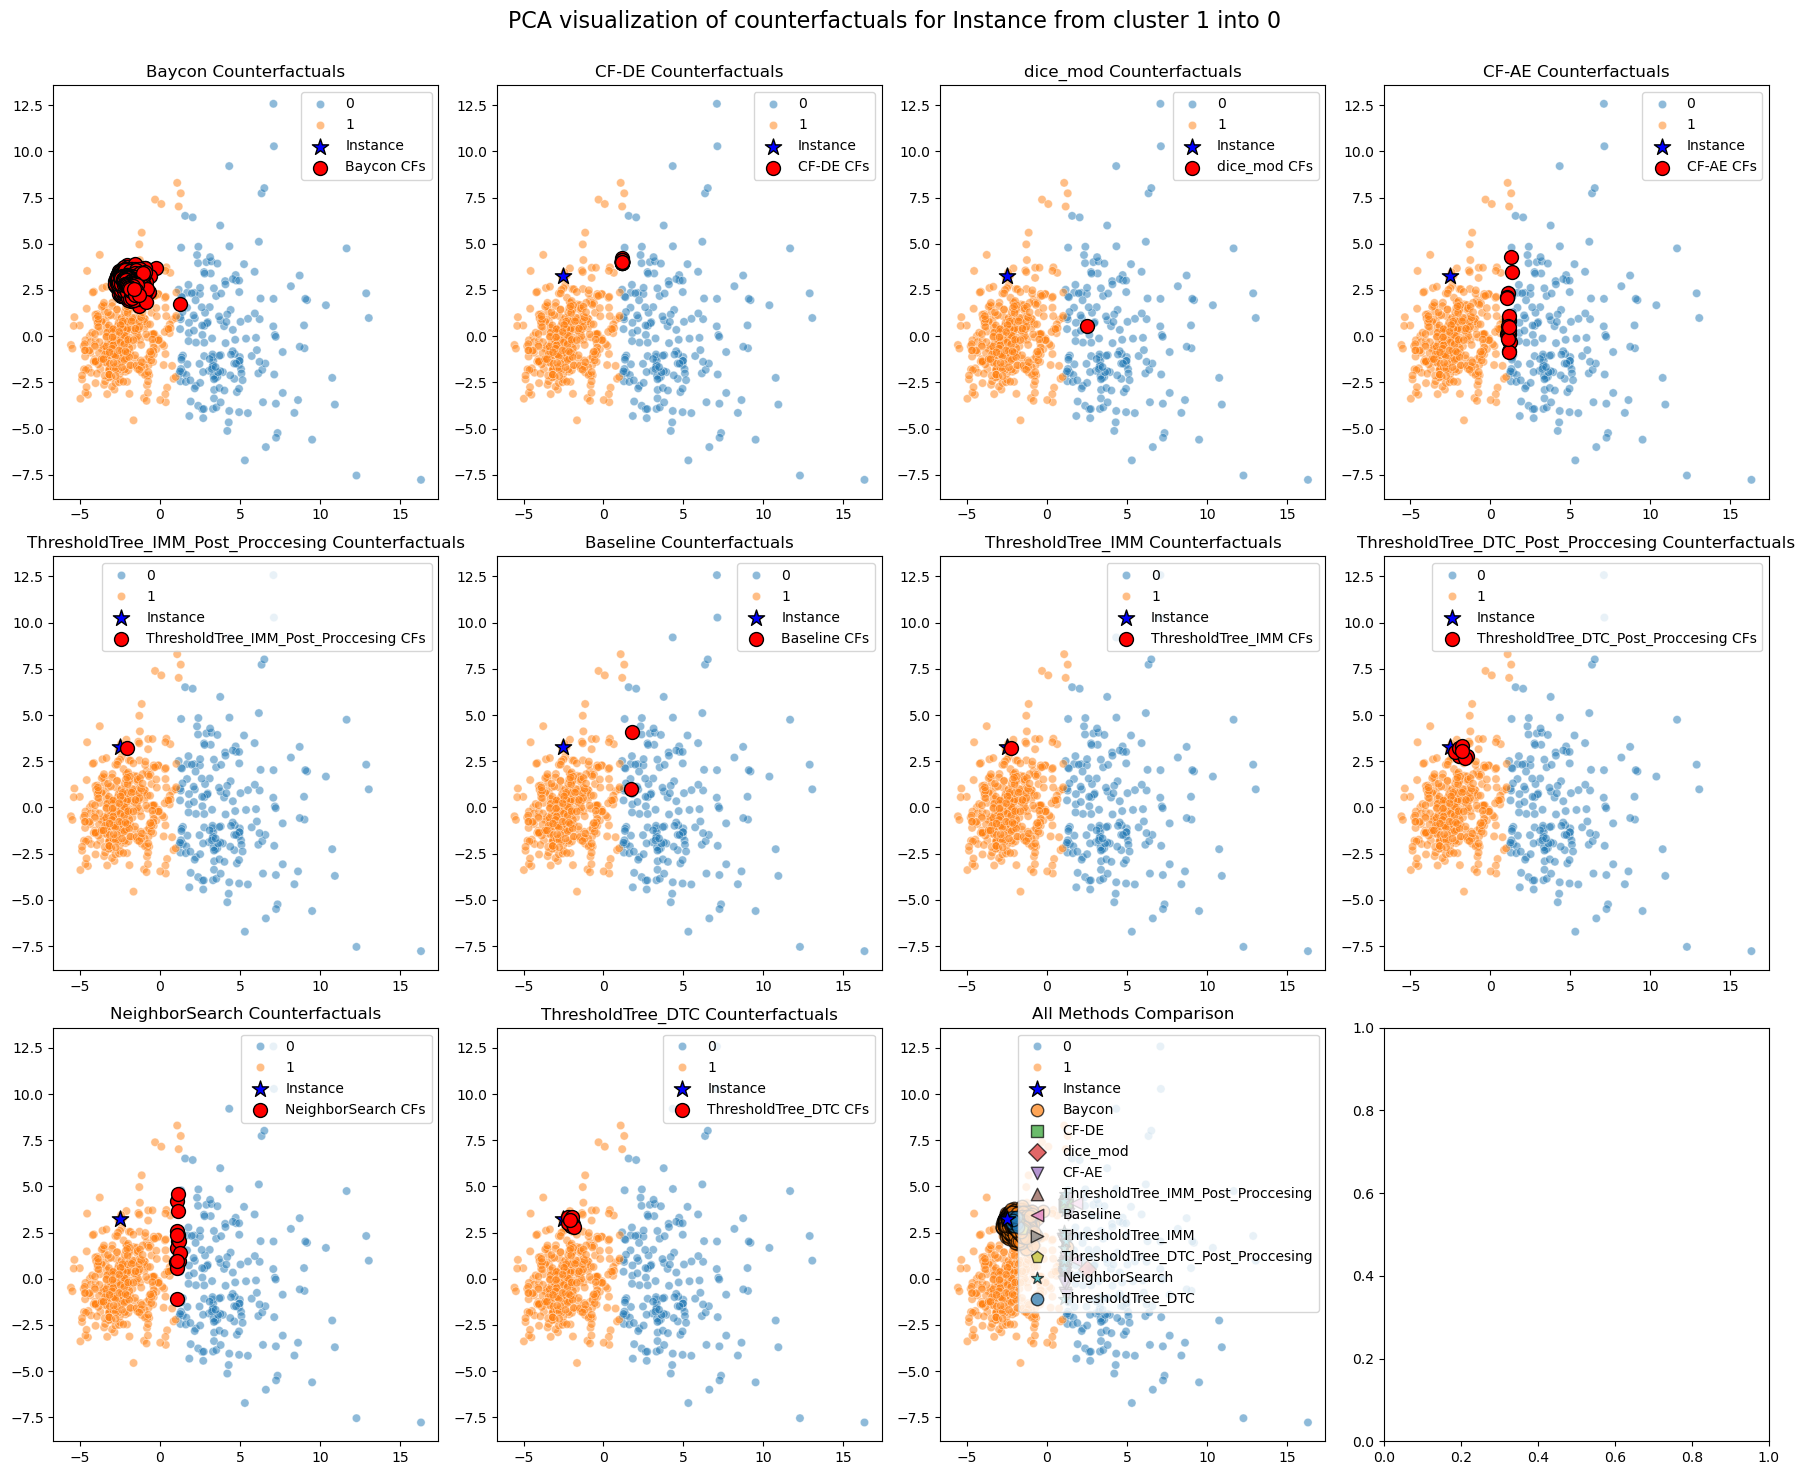

In [ ]:
cf_n = 0

fig, axs = plt.subplots(3, 4, figsize=(18, 15))
axs = axs.flatten()

cffDict = methods

instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

methods_embedded = [
    (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
    for m in methods
]

# Base scatterplot of the data
for i in range(len(methods_embedded)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods_embedded):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*', 'o']
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Running time

In [ ]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, model=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 510 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (777) CFs (0)
Re-training surrogate model with data size: 777
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (19) Unique overall (19)
Generated random instances: (3712)
Predicted top: 20 Counterfactuals: 2
Found new best [ 1.72559641 -1.07036908 -0.64499872  1.17634359 -1.09383285 -0.14651359
  0.98622238  1.39425863 -1.14135292  0.72265486 -0.76793904 -1.04352611
  0.32175406 -0.60058241 -0.38801373  1.17783404  0.27441693  0.56511624
  0.24914339  1.14500318 -0.79088749  1.25278009  0.43278108  0.0885218
 -1.09890416  0.1592573   0.79641289  1.2627     -0.48008564  0.56818724], with fitness score 0.4619 (X 0.86609 Y 1.0 F 0.53333), oversampling
Known alternatives: 797
Best instance score 0.4619 (X 0.866

KeyboardInterrupt: 